In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 2  # Real and Spoof classes
MAX_EPOCHS = 10  # Maximum number of epochs
PATIENCE = 5  # Number of epochs to wait before early stopping if validation loss doesn't improve

In [ ]:
train_data_dir = '/content/drive/MyDrive/datafinal/train'
test_data_dir = '/content/drive/MyDrive/datafinal/test'

In [ ]:
# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['real', 'spoof']
)

Found 4220 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=['real', 'spoof']
)

Found 951 images belonging to 2 classes.


In [ ]:
# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout regularization added

# Additional layers for efficiency
output = Flatten()(x)
output = Dropout(0.3)(output)
output = Dense(units=8, activation='relu')(output)
prediction = Dense(1, activation='sigmoid')(output)

In [ ]:
# Create model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=MAX_EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping]  # Include early stopping callback
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_accuracy}")

# Save the trained model
model.save('face_liveness_detection_model.h5')

Epoch 1/10
131/131 [==============================] - 273s 2s/step - loss: 0.2346 - accuracy: 0.9157 - val_loss: 0.0597 - val_accuracy: 0.9817
Epoch 2/10
131/131 [==============================] - 243s 2s/step - loss: 0.0438 - accuracy: 0.9883 - val_loss: 0.0359 - val_accuracy: 0.9892
Epoch 3/10
131/131 [==============================] - 239s 2s/step - loss: 0.0350 - accuracy: 0.9902 - val_loss: 0.0198 - val_accuracy: 0.9946
Epoch 4/10
131/131 [==============================] - 240s 2s/step - loss: 0.0337 - accuracy: 0.9883 - val_loss: 0.0286 - val_accuracy: 0.9892
Epoch 5/10
131/131 [==============================] - 240s 2s/step - loss: 0.0417 - accuracy: 0.9835 - val_loss: 0.0114 - val_accuracy: 0.9978
Epoch 6/10
131/131 [==============================] - 241s 2s/step - loss: 0.0232 - accuracy: 0.9919 - val_loss: 0.0262 - val_accuracy: 0.9881
Epoch 7/10
131/131 [==============================] - 233s 2s/step - loss: 0.0217 - accuracy: 0.9926 - val_loss: 0.0179 - val_accuracy: 0.9957

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


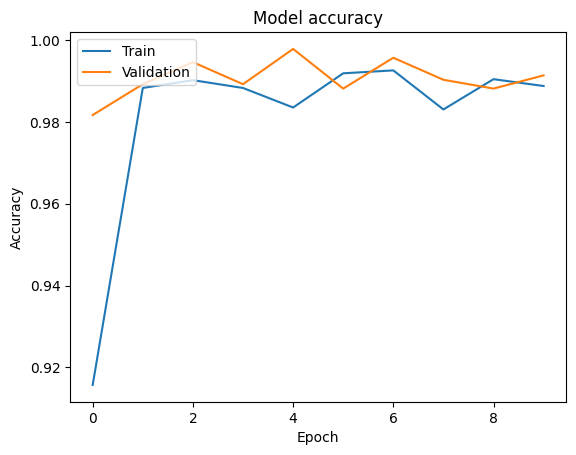

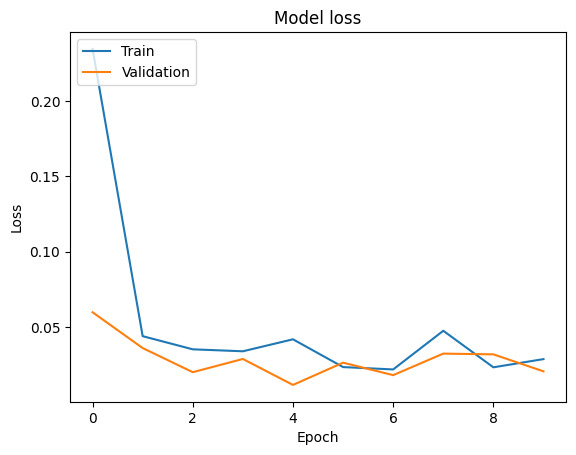

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Assuming you have 'history' object from model training
plot_training_history(history)


30/30 [==============================] - 36s 1s/step


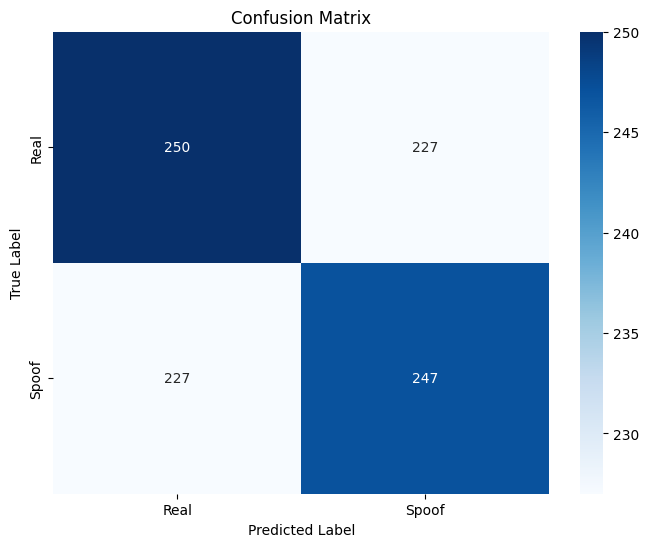

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes for test data
y_true = test_generator.classes  # True classes
y_pred = model.predict(test_generator) > 0.5  # Predicted classes (using 0.5 threshold for binary classification)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
labels = ['Real', 'Spoof']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Calculate accuracy
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)

# Calculate precision
true_positives = conf_matrix[1, 1]
false_positives = conf_matrix[0, 1]
precision = true_positives / (true_positives + false_positives)

